##### LSTM Network - Prediction (model training)

The example below will build the LSTM model on the FTSE 100 up to today (2025-12-23) and split the training/validation. Then the prediction module will look ahead 300 days and try to make a  prediction based on a random generation. 

In [2]:
%%capture
%pip install -r requirements.txt

In [3]:
# Copyright 2020-2026 Jordi Corbilla. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

import os
import warnings
import secrets
import pandas as pd
import argparse
import numpy as np
import pickle

from stock_prediction_class import StockPrediction
from stock_prediction_lstm import LongShortTermMemory
from stock_prediction_numpy import StockData
from stock_prediction_plotter import Plotter
from stock_prediction_readme_generator import ReadmeGenerator
from stock_prediction_deep_learning import train_LSTM_network

# Suppress TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or '3' to suppress all messages

# Suppress other warnings
warnings.filterwarnings("ignore", category=UserWarning, module="tensorflow")
warnings.filterwarnings("ignore", message=".*np.object.*", category=FutureWarning)

import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import timedelta, datetime
from pandas.tseries.offsets import BDay

os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

Ticker: GOOG
Start Date: 2017-01-01
Validation Date: 2017-01-01
Test Run Folder: GOOG_20251228_b8fb03d2497b213db77cc88d53f13c90
plotting Data and Histogram


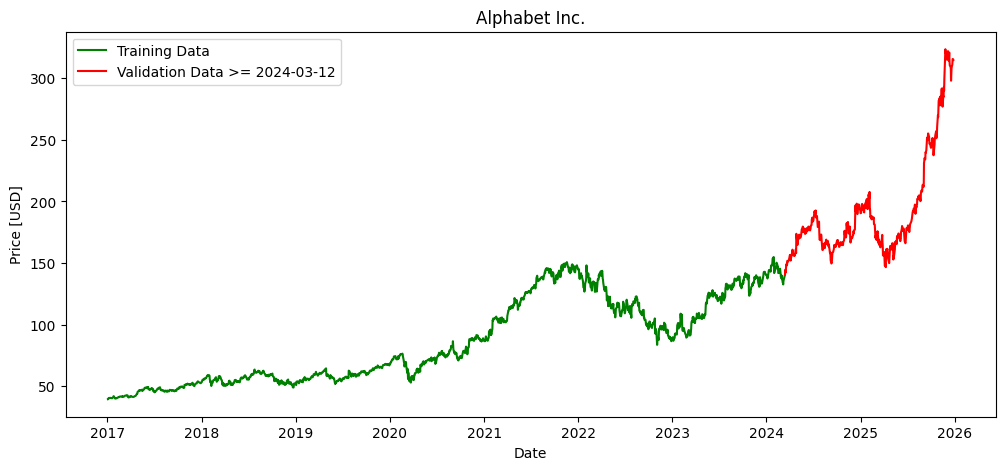

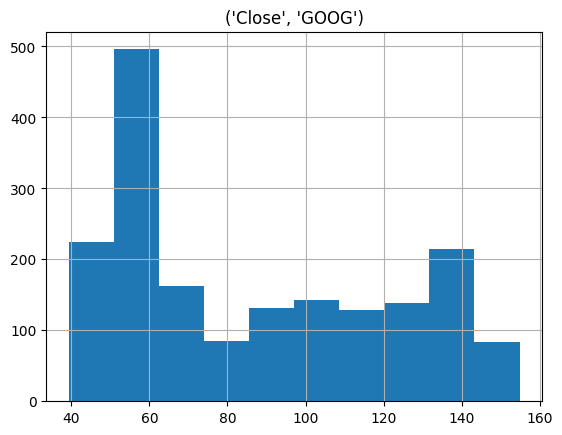

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 128)             │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 116,033 (453.25 KB)

 Trainable params: 116,033 (453.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.5177 - loss: 0.6943 - val_accuracy: 0.5689 - val_loss: 0.6847 - learning_rate: 0.0010
Epoch 2/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.5349 - loss: 0.6917 - val_accuracy: 0.5689 - val_loss: 0.6880 - learning_rate: 0.0010
Epoch 3/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.5366 - loss: 0.6915 - val_accuracy: 0.5689 - val_loss: 0.6852 - learning_rate: 0.0010
Epoch 4/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.5378 - loss: 0.6912 - val_accuracy: 0.5689 - val_loss: 0.6840 - learning_rate: 0.0010
Epoch 5/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.5383 - loss: 0.6911 - val_accuracy: 0.5689 - val_loss: 0.6870 - learning_rate: 0.0010
Epoch 6/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.5383 - loss: 0.6911 - val_accuracy: 0.5689 - val_loss: 0.6886 - learning_rate: 0.0010
Epoch 7/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5465 - l

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 60, 128)             │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 60, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 116,033 (453.25 KB)

 Trainable params: 116,033 (453.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - MSE: 0.0093 - loss: 0.0047 - val_MSE: 0.0380 - val_loss: 0.0189 - learning_rate: 0.0010
Epoch 2/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - MSE: 0.0091 - loss: 0.0045 - val_MSE: 0.0378 - val_loss: 0.0188 - learning_rate: 0.0010
Epoch 3/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - MSE: 0.0088 - loss: 0.0044 - val_MSE: 0.0365 - val_loss: 0.0181 - learning_rate: 0.0010
Epoch 4/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - MSE: 0.0087 - loss: 0.0043 - val_MSE: 0.0359 - val_loss: 0.0179 - learning_rate: 0.0010
Epoch 5/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - MSE: 0.0087 - loss: 0.0043 - val_MSE: 0.0384 - val_loss: 0.0191 - learning_rate: 0.0010
Epoch 6/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - MSE: 0.0087 - loss: 0.0044 - val_MSE: 0.0370 - val_loss: 0.0184 - learning_rate: 0.0010
Epoch 7/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - MSE: 0.0086 - loss: 0.0043
Epoch 7: ReduceLROnPlateau reducing learning rate to 

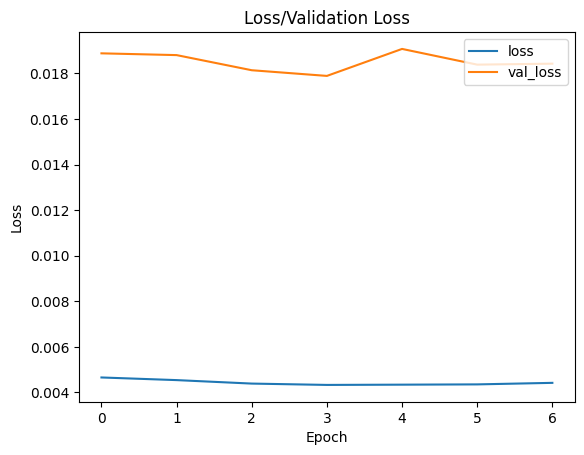

plotting MSE


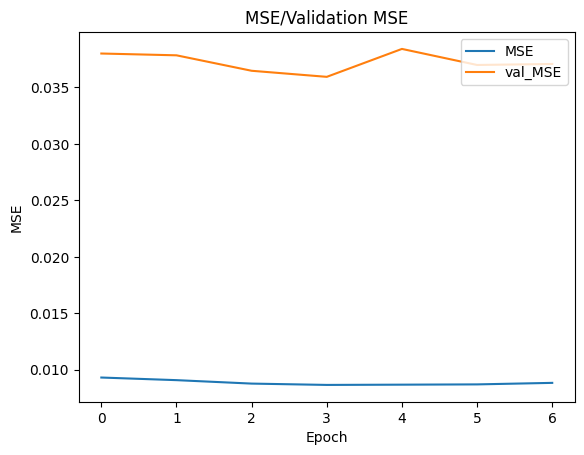

display the content of the model
15/15 - 1s - 38ms/step - MSE: 0.0371 - loss: 0.0184
loss :  0.018431222066283226
compile_metrics :  0.03707750886678696

plotting prediction results
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
plotting predictions


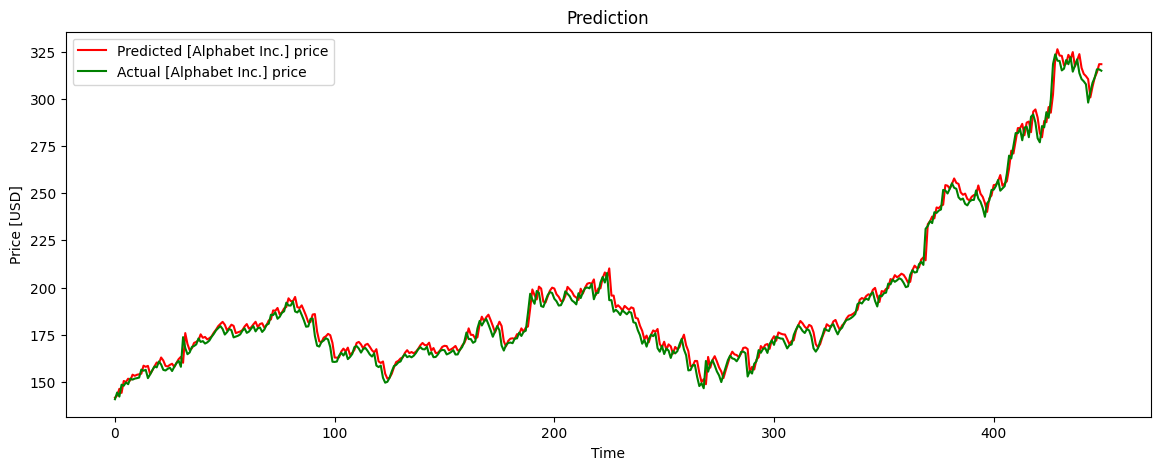

prediction is finished


In [4]:
STOCK_TICKER = "GOOG"
STOCK_START_DATE = pd.to_datetime('2017-01-01')
end_date = datetime.today()
duration = end_date - STOCK_START_DATE
STOCK_VALIDATION_DATE = STOCK_START_DATE + 0.8 * duration
EPOCHS = 100
BATCH_SIZE = 10
TIME_STEPS = 60
USE_RETURNS = False
CLIP_NEGATIVE = True
FORECAST_DAYS = 10
TODAY_RUN = datetime.today().strftime("%Y%m%d")
TOKEN = STOCK_TICKER + '_' + TODAY_RUN + '_' + secrets.token_hex(16)
GITHUB_URL = "https://github.com/JordiCorbilla/stock-prediction-deep-neural-learning/raw/master/"
print('Ticker: ' + STOCK_TICKER)
print('Start Date: ' + STOCK_START_DATE.strftime("%Y-%m-%d"))
print('Validation Date: ' + STOCK_START_DATE.strftime("%Y-%m-%d"))
print('Test Run Folder: ' + TOKEN)
# create project run folder
PROJECT_FOLDER = os.path.join(os.getcwd(), TOKEN)
if not os.path.exists(PROJECT_FOLDER):
    os.makedirs(PROJECT_FOLDER)

stock_prediction = StockPrediction(STOCK_TICKER, 
                                   STOCK_START_DATE, 
                                   STOCK_VALIDATION_DATE, 
                                   PROJECT_FOLDER, 
                                   GITHUB_URL,
                                   EPOCHS,
                                   TIME_STEPS,
                                   TOKEN,
                                   BATCH_SIZE)
# Execute Deep Learning model
train_LSTM_network(stock_prediction, USE_RETURNS, model_version='v7', forecast_horizon=FORECAST_DAYS, trend_window=60)

## Infer the Future Data (Predictions)

2.18.1
Latest Stock Price
314.9599914550781
Latest Date
2025-12-26 00:00:00


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 128)             │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 116,033 (453.25 KB)

 Trainable params: 116,033 (453.25 KB)

 Non-trainable params: 0 (0.00 B)

Inference progress: 0/30
Predicted batch size: 1
Inference progress: 3/30
Inference progress: 3/30
Inference progress: 6/30
Inference progress: 6/30
Inference progress: 9/30
Inference progress: 9/30
Inference progress: 12/30
Inference progress: 12/30
Inference progress: 15/30
Inference progress: 15/30
Inference progress: 18/30
Inference progress: 18/30
Inference progress: 21/30
Inference progress: 21/30
Inference progress: 24/30
Inference progress: 24/30
Inference progress: 27/30
Inference progress: 27/30
Inference progress: 30/30
Sanity check - next day delta: -0.52%


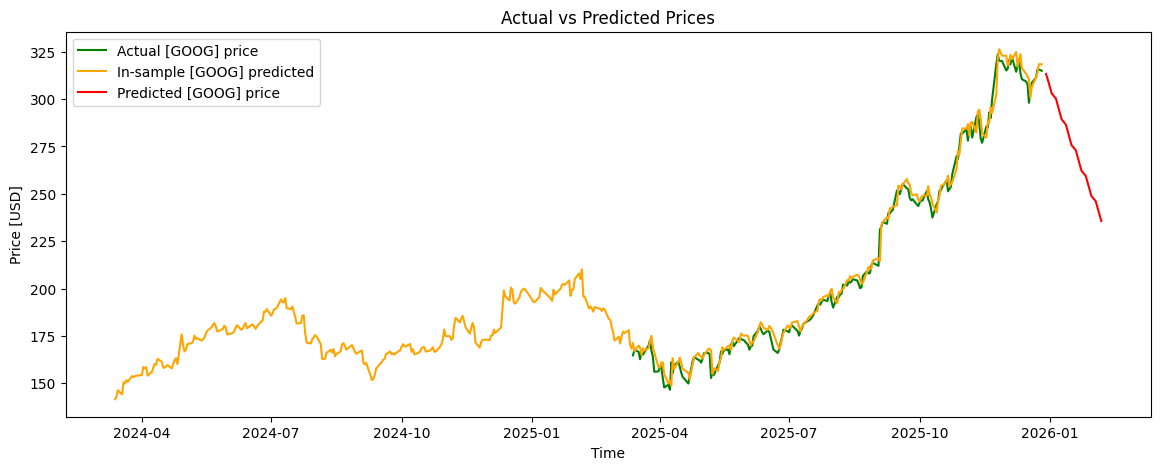

In [6]:
DIRECTION_THRESHOLD = 0.55
MAG_CLIP_PCT = 90

BLEND_ALPHA = 0.6

from stock_prediction_deep_learning_inference import InferenceRunner
FORECAST_DAYS = 30
USE_BUSINESS_DAYS = True
PLOT_HISTORY_DAYS = 200
USE_RETURNS = False
USE_DELTAS = False
CLIP_NEGATIVE = True
runner = InferenceRunner(
    run_folder=PROJECT_FOLDER,
    ticker=STOCK_TICKER,
    start_date=STOCK_START_DATE,
    validation_date=STOCK_VALIDATION_DATE,
    github_url=GITHUB_URL,
    epochs=EPOCHS,
    time_steps=TIME_STEPS,
    token=TOKEN,
    batch_size=BATCH_SIZE,
    forecast_days=FORECAST_DAYS,
    use_business_days=USE_BUSINESS_DAYS,
    plot_history_days=PLOT_HISTORY_DAYS,
    use_returns=USE_RETURNS,
    use_deltas=USE_DELTAS,
    clip_negative=CLIP_NEGATIVE,
    blend_alpha=BLEND_ALPHA,
    direction_threshold=DIRECTION_THRESHOLD,
    mag_clip_pct=MAG_CLIP_PCT,
)
runner.run()


In [7]:
import pandas as pd, os
df = pd.read_csv(os.path.join(PROJECT_FOLDER, "future_predictions.csv"))
print(df[['Predicted_Price', 'Predicted_Price_Raw']].head())

   Predicted_Price  Predicted_Price_Raw
0       313.313166           312.215282
1       311.007043           309.469628
2       308.436812           306.723324
3       305.760847           303.976870
4       303.042838           301.230833
